# Setup

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, regularizers, backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dropout
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import glob

### load data

In [3]:
x_train = np.load('damped_pendulum_data_train.npy')
x_val = np.load('damped_pendulum_data_valid.npy')
x_test = np.load('damped_pendulum_data_test.npy')

kappas_tr, betas_tr = np.loadtxt('damped_pendulum_data_params_train.dat', unpack=True)
kappas_va, betas_va = np.loadtxt('damped_pendulum_data_params_valid.dat', unpack=True)
kappas_te, betas_te = np.loadtxt('damped_pendulum_data_params_test.dat', unpack=True)

rtimes_tr = np.load('rtimes_tr.npy')
rtimes_va = np.load('rtimes_va.npy')
rtimes_te = np.load('rtimes_te.npy')

answers_tr = np.load('answers_tr.npy')
answers_va = np.load('answers_va.npy')
answers_te = np.load('answers_te.npy')

In [4]:
rtimes_tr = rtimes_tr.T
rtimes_va = rtimes_va.T
rtimes_te = rtimes_te.T

answers_tr = answers_tr.T
answers_va = answers_va.T
answers_te = answers_te.T

In [5]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Neural Network

In [239]:
num_hidden_layers = 2
encoding_dim = 3
input_dim = x_train.shape[1]
hidden_dim = 100
batch_size = 1024
epochs = 1000
learning_rate = 0.01
regul=0.000105
regul2=0.0003

factor = 0.25
patience = 50
min_lr = 0.000001
verbose = 1

In [240]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=factor,
                                                 patience=patience, 
                                                 min_lr=min_lr, 
                                                 verbose=verbose
                                                )

In [241]:
early_stopping_callback = EarlyStopping(
    patience=patience,
    monitor='val_loss',
    mode='min',
    verbose=verbose
)

## Autoencoder

In [242]:
encoder_input = keras.Input(shape=(input_dim,))
rtimes_input = keras.Input(shape=(1,))

#encoder 
x = layers.Dense(5*hidden_dim, activation='relu', activity_regularizer=regularizers.L1(regul2))(encoder_input)
for i in range(num_hidden_layers):
    x = layers.Dense(hidden_dim, activation='relu', activity_regularizer=regularizers.L1(regul2))(x)
z_mean = layers.Dense(encoding_dim, activity_regularizer=regularizers.L1(regul))(x)
z_log_var = layers.Dense(encoding_dim, activity_regularizer=regularizers.L1(regul))(x)

z = Sampling()([z_mean, z_log_var])

decoder_input = keras.Input(shape=(encoding_dim+1,)) #1 -> question

#decoder
x = layers.Dense(hidden_dim, activation='relu', activity_regularizer=regularizers.L1(regul2))(decoder_input)
for i in range(num_hidden_layers-1):
    x = layers.Dense(hidden_dim, activation='relu', activity_regularizer=regularizers.L1(regul2))(x)
x = layers.Dense(5*hidden_dim, activation='relu', activity_regularizer=regularizers.L1(regul2))(x)
decoded = layers.Dense(1, activation='linear')(x)

encoder = keras.Model(encoder_input, [z_mean, z_log_var, z], name='encoder')
decoder = keras.Model(decoder_input, decoded, name='decoder')

autoencoder = keras.Model([encoder_input, rtimes_input], decoder(tf.concat(values=[encoder(encoder_input)[2], rtimes_input], axis=1)))

In [243]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                    loss='mae', metrics=['mse'])

## training the model

In [244]:
fitting_output = autoencoder.fit([x_train, rtimes_tr], answers_tr, 
                                 epochs=epochs,
                                 batch_size=batch_size,
                                 validation_data=([x_val, rtimes_va], answers_va),
                                 callbacks=[reduce_lr, early_stopping_callback])

Epoch 1/1000
14/14 [==============================] - 4s 40ms/step - loss: 0.9864 - mse: 5.3214 - val_loss: 0.1970 - val_mse: 0.0877 - lr: 0.0100
Epoch 2/1000
14/14 [==============================] - 0s 22ms/step - loss: 0.1903 - mse: 0.0841 - val_loss: 0.1838 - val_mse: 0.0781 - lr: 0.0100
Epoch 3/1000
14/14 [==============================] - 0s 19ms/step - loss: 0.1814 - mse: 0.0780 - val_loss: 0.1783 - val_mse: 0.0754 - lr: 0.0100
Epoch 4/1000
14/14 [==============================] - 0s 16ms/step - loss: 0.1793 - mse: 0.0773 - val_loss: 0.1774 - val_mse: 0.0745 - lr: 0.0100
Epoch 5/1000
14/14 [==============================] - 0s 17ms/step - loss: 0.1773 - mse: 0.0759 - val_loss: 0.1756 - val_mse: 0.0729 - lr: 0.0100
Epoch 6/1000
14/14 [==============================] - 0s 18ms/step - loss: 0.1741 - mse: 0.0739 - val_loss: 0.1715 - val_mse: 0.0705 - lr: 0.0100
Epoch 7/1000
14/14 [==============================] - 0s 17ms/step - loss: 0.1722 - mse: 0.0723 - val_loss: 0.1694 - val_mse

Epoch 57/1000
14/14 [==============================] - 0s 18ms/step - loss: 0.1597 - mse: 0.0692 - val_loss: 0.1582 - val_mse: 0.0671 - lr: 0.0100
Epoch 58/1000
14/14 [==============================] - 0s 18ms/step - loss: 0.1591 - mse: 0.0686 - val_loss: 0.1581 - val_mse: 0.0668 - lr: 0.0100
Epoch 59/1000
14/14 [==============================] - 0s 19ms/step - loss: 0.1597 - mse: 0.0689 - val_loss: 0.1575 - val_mse: 0.0662 - lr: 0.0100
Epoch 60/1000
14/14 [==============================] - 0s 20ms/step - loss: 0.1595 - mse: 0.0689 - val_loss: 0.1580 - val_mse: 0.0665 - lr: 0.0100
Epoch 61/1000
14/14 [==============================] - 0s 18ms/step - loss: 0.1592 - mse: 0.0688 - val_loss: 0.1579 - val_mse: 0.0665 - lr: 0.0100
Epoch 62/1000
14/14 [==============================] - 0s 19ms/step - loss: 0.1588 - mse: 0.0686 - val_loss: 0.1581 - val_mse: 0.0671 - lr: 0.0100
Epoch 63/1000
14/14 [==============================] - 0s 18ms/step - loss: 0.1596 - mse: 0.0696 - val_loss: 0.1579 - 

Epoch 113/1000
14/14 [==============================] - 0s 18ms/step - loss: 0.1588 - mse: 0.0688 - val_loss: 0.1568 - val_mse: 0.0665 - lr: 0.0100
Epoch 114/1000
14/14 [==============================] - 0s 19ms/step - loss: 0.1588 - mse: 0.0690 - val_loss: 0.1567 - val_mse: 0.0661 - lr: 0.0100
Epoch 115/1000
14/14 [==============================] - 0s 21ms/step - loss: 0.1583 - mse: 0.0686 - val_loss: 0.1566 - val_mse: 0.0662 - lr: 0.0100
Epoch 116/1000
14/14 [==============================] - 0s 19ms/step - loss: 0.1583 - mse: 0.0687 - val_loss: 0.1567 - val_mse: 0.0658 - lr: 0.0100
Epoch 117/1000
14/14 [==============================] - 0s 19ms/step - loss: 0.1579 - mse: 0.0683 - val_loss: 0.1579 - val_mse: 0.0674 - lr: 0.0100
Epoch 118/1000
14/14 [==============================] - 0s 18ms/step - loss: 0.1586 - mse: 0.0687 - val_loss: 0.1566 - val_mse: 0.0662 - lr: 0.0100
Epoch 119/1000
14/14 [==============================] - 0s 18ms/step - loss: 0.1584 - mse: 0.0687 - val_loss: 0.

14/14 [==============================] - 0s 18ms/step - loss: 0.1582 - mse: 0.0687 - val_loss: 0.1568 - val_mse: 0.0663 - lr: 0.0100
Epoch 169/1000
14/14 [==============================] - 0s 17ms/step - loss: 0.1581 - mse: 0.0684 - val_loss: 0.1570 - val_mse: 0.0669 - lr: 0.0100
Epoch 170/1000
14/14 [==============================] - 0s 18ms/step - loss: 0.1585 - mse: 0.0691 - val_loss: 0.1566 - val_mse: 0.0663 - lr: 0.0100
Epoch 171/1000
14/14 [==============================] - 0s 18ms/step - loss: 0.1583 - mse: 0.0687 - val_loss: 0.1568 - val_mse: 0.0660 - lr: 0.0100
Epoch 172/1000
14/14 [==============================] - 0s 18ms/step - loss: 0.1583 - mse: 0.0686 - val_loss: 0.1568 - val_mse: 0.0662 - lr: 0.0100
Epoch 173/1000
14/14 [==============================] - 0s 18ms/step - loss: 0.1581 - mse: 0.0684 - val_loss: 0.1567 - val_mse: 0.0666 - lr: 0.0100
Epoch 174/1000
14/14 [==============================] - 0s 18ms/step - loss: 0.1581 - mse: 0.0684 - val_loss: 0.1570 - val_mse:

14/14 [==============================] - 0s 18ms/step - loss: 0.1582 - mse: 0.0686 - val_loss: 0.1565 - val_mse: 0.0663 - lr: 0.0100
Epoch 224/1000
14/14 [==============================] - 0s 18ms/step - loss: 0.1582 - mse: 0.0683 - val_loss: 0.1571 - val_mse: 0.0663 - lr: 0.0100
Epoch 225/1000
14/14 [==============================] - 0s 18ms/step - loss: 0.1582 - mse: 0.0685 - val_loss: 0.1566 - val_mse: 0.0660 - lr: 0.0100
Epoch 226/1000
14/14 [==============================] - 0s 18ms/step - loss: 0.1577 - mse: 0.0684 - val_loss: 0.1569 - val_mse: 0.0660 - lr: 0.0100
Epoch 227/1000
14/14 [==============================] - 0s 18ms/step - loss: 0.1580 - mse: 0.0684 - val_loss: 0.1564 - val_mse: 0.0664 - lr: 0.0100
Epoch 228/1000
14/14 [==============================] - 0s 18ms/step - loss: 0.1585 - mse: 0.0689 - val_loss: 0.1581 - val_mse: 0.0683 - lr: 0.0100
Epoch 229/1000
14/14 [==============================] - 0s 18ms/step - loss: 0.1582 - mse: 0.0685 - val_loss: 0.1571 - val_mse:

In [245]:
training_history = fitting_output.history

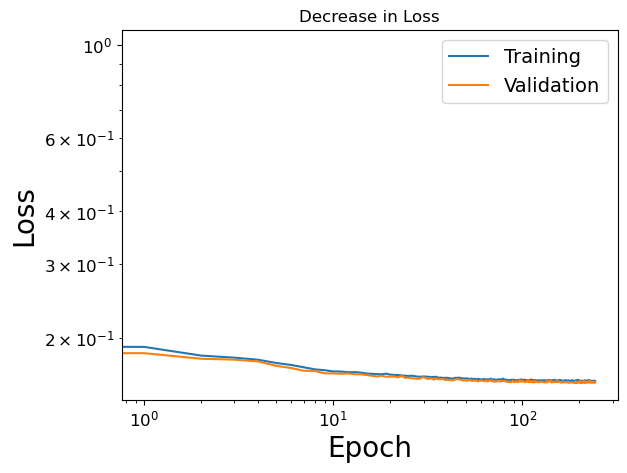

In [246]:
# plotting the decrease in loss as the network learns
fig_loss = plt.figure()
ax = fig_loss.add_subplot(111)
ax.loglog(fitting_output.history['loss'], label='Training')
ax.plot(fitting_output.history['val_loss'], label='Validation')
ax.set_title('Decrease in Loss')
ax.set_ylabel('Loss', fontsize=20)
ax.set_xlabel('Epoch', fontsize=20)
ax.legend(loc='upper right', fontsize=14)
ax.tick_params(axis='both', which='both', labelsize=12)
# ax.set_xticks(np.arange(0, epochs, 1))
#ax.set_ylim(0, 0.3)
plt.show()

## testing the model

In [247]:
# compare autoencoder model to encoder and decoder models

f1 = autoencoder.predict([x_test, rtimes_te])
f2 = decoder(np.concatenate((encoder(x_test)[2].numpy(), rtimes_te), axis=1))

63/63 [==============================] - 0s 2ms/step


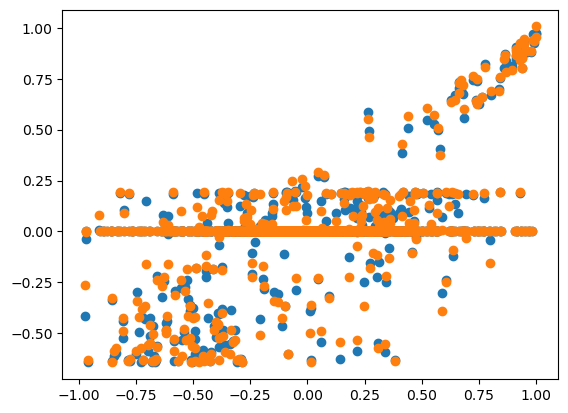

In [248]:
plt.plot(answers_te, f1, 'o')
plt.plot(answers_te, f2, 'o')

In [249]:
encoded_data = encoder(x_test)[2]

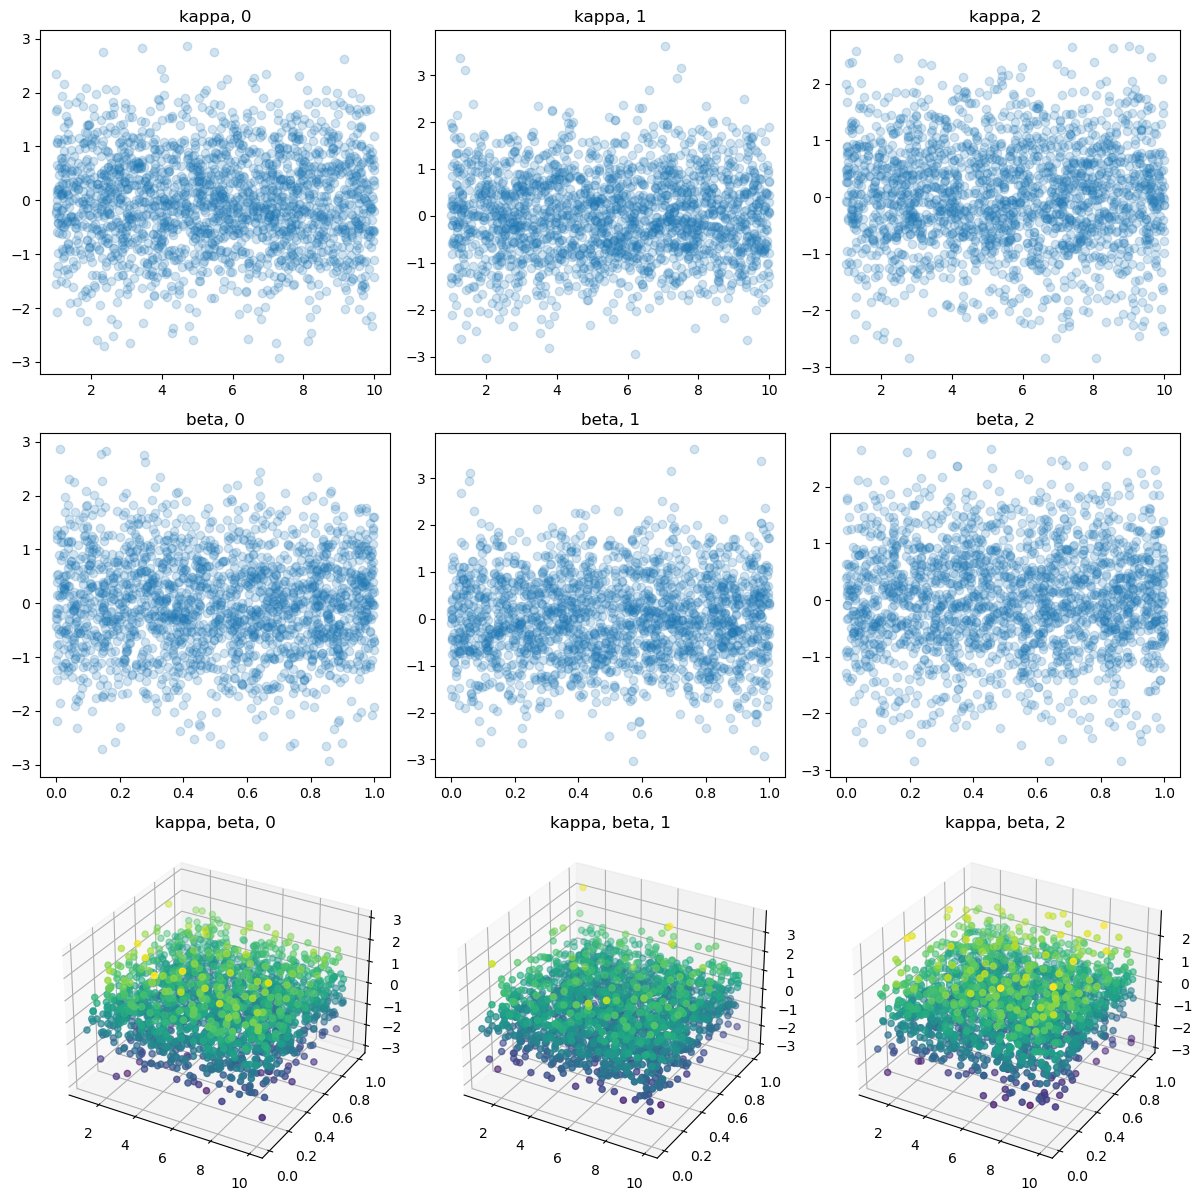

In [250]:
graphs = 'graphs_for_report'
save_path = f"b:{batch_size}_lr:{learning_rate}_r:{regul}_r2:{regul2}"

fig = plt.figure(figsize=(12, 12))

ax1 = fig.add_subplot(331)
ax1.plot(kappas_te, encoded_data[:, 0], 'o', alpha=0.2)
ax1.set_title('kappa, 0')

ax2 = fig.add_subplot(334)
ax2.plot(betas_te, encoded_data[:, 0], 'o', alpha=0.2)
ax2.set_title('beta, 0')

ax3 = fig.add_subplot(332)
ax3.plot(kappas_te, encoded_data[:, 1], 'o', alpha=0.2)
ax3.set_title('kappa, 1')

ax4 = fig.add_subplot(335)
ax4.plot(betas_te, encoded_data[:, 1], 'o', alpha=0.2)
ax4.set_title('beta, 1')

ax5 = fig.add_subplot(333)
ax5.plot(kappas_te, encoded_data[:, 2], 'o', alpha=0.2)
ax5.set_title('kappa, 2')

ax6 = fig.add_subplot(336)
ax6.plot(betas_te, encoded_data[:, 2], 'o', alpha=0.2)
ax6.set_title('beta, 2')

ax7 = fig.add_subplot(337, projection='3d')
ax7.scatter(kappas_te, betas_te, encoded_data[:, 0], c=encoded_data[:, 0])
ax7.set_title('kappa, beta, 0')

ax8 = fig.add_subplot(338, projection='3d')
ax8.scatter(kappas_te, betas_te, encoded_data[:, 1], c=encoded_data[:, 1])
ax8.set_title('kappa, beta, 1')

ax9 = fig.add_subplot(339, projection='3d')
ax9.scatter(kappas_te, betas_te, encoded_data[:, 2], c=encoded_data[:, 2])
ax9.set_title('kappa, beta, 2')

plt.tight_layout()
graphs_file_path = os.path.join(graphs, save_path)
plt.savefig(os.path.join(f"{graphs_file_path}.png"))
plt.show()
plt.close(fig)